# Emotion Classifier Model

- Here my goal was to use the https://github.com/akmadan/Emotion_Detection_CNN/tree/main emotion detection model with the https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset dataset to create a working OpenCV inference script to deploy a real-time CNN custom-built classifier to predict 7 emotions, and then to combine this with a pretrained model using transfer learning to predict gender, based on this model/dataset https://www.kaggle.com/datasets/trainingdatapro/gender-detection-and-classification-image-dataset. 

- The target accuracy for both models, based on the results from the aforementioned two existing models, is between 60% and 75%.

- Below is an image showing the two models successfully operating together.

<img src="prediction_example.png" alt="Sample Prediction" width="500"/>

- I will give a brief overview of what I tried and discuss the results, along with my interpretation of what happened and what are the suggested next steps at the end of this model script.

### Importing Libraries

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, MaxPooling2D, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
import tensorflow as tf
#from tensorflow.keras.utils import to_categorical

### Load Data and display images

##### Directories

In [68]:
data_dir = r"C:\Users\rshaw\Desktop\EC Utbildning - Data Science\Kurs 7 - Deep Learning\Kunskapkontroll2-ComputerVision\Emotion_Detection_CNN\images"
train_dir = r"C:\Users\rshaw\Desktop\EC Utbildning - Data Science\Kurs 7 - Deep Learning\Kunskapkontroll2-ComputerVision\Emotion_Detection_CNN\images\train"
validation_dir = r"C:\Users\rshaw\Desktop\EC Utbildning - Data Science\Kurs 7 - Deep Learning\Kunskapkontroll2-ComputerVision\Emotion_Detection_CNN\images\validation"

##### Parameters

In [69]:
# Parameters
picture_size = 48
batch_size = 128
no_of_classes = 7
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [70]:
#Here we double-check the class count in both train and validation sets
class_names = os.listdir(data_dir)
class_counts = {}
 
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    num_samples = len(os.listdir(class_dir))
    class_counts[class_name] = num_samples
 
print("Class Counts:", class_counts)

Class Counts: {'train': 7, 'validation': 7}


In [71]:
# Here we see the class balance in both the training set and below in the validation set are quite uneven, which could effect the ability for the model to accurately distinguish classes and assign weights 
# properly.

class_names = os.listdir(train_dir)
class_counts = {}
 
for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    num_samples = len(os.listdir(class_dir))
    class_counts[class_name] = num_samples
 
print("Class Counts:", class_counts)

Class Counts: {'angry': 3993, 'disgust': 436, 'fear': 4103, 'happy': 7164, 'neutral': 4982, 'sad': 4938, 'surprise': 3205}


In [72]:
class_names = os.listdir(validation_dir)
class_counts = {}
 
for class_name in class_names:
    class_dir = os.path.join(validation_dir, class_name)
    num_samples = len(os.listdir(class_dir))
    class_counts[class_name] = num_samples
 
print("Class Counts:", class_counts)

Class Counts: {'angry': 960, 'disgust': 111, 'fear': 1018, 'happy': 1825, 'neutral': 1216, 'sad': 1139, 'surprise': 797}


In [73]:
# So here we create a dictionary to list each class according to its image numbers and manually use sklearn to calculate the associated class weights
num_images = {
    'angry': 3993,
    'disgust': 436,
    'fear': 4103,
    'happy': 7164,
    'sad': 4938,
    'surprise': 3205,
   'neutral': 4982
}
total_images = sum(num_images.values())
class_weights = {i: total_images / (len(num_images) * num_images[class_name]) for i, class_name in enumerate(num_images)}
print(class_weights)

{0: 1.031125898894494, 1: 9.443315858453474, 2: 1.0034817729187702, 3: 0.5747188322565207, 4: 0.8337962159347335, 5: 1.2846445286382884, 6: 0.8264322991340254}


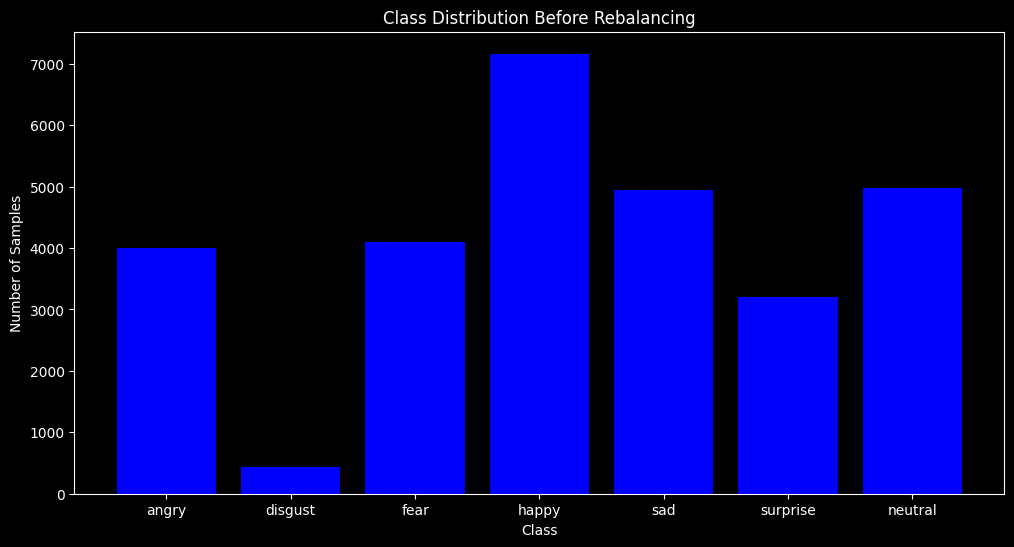

In [74]:
classes = list(num_images.keys())
num_samples = list(num_images.values())

plt.figure(figsize=(12, 6))
plt.bar(classes, num_samples, color='blue')
plt.title('Class Distribution Before Rebalancing')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

Above you can clearly see the likelihood that "disgust" will be very hard for the CNN model to accurately distinguish and "happy" much easier.

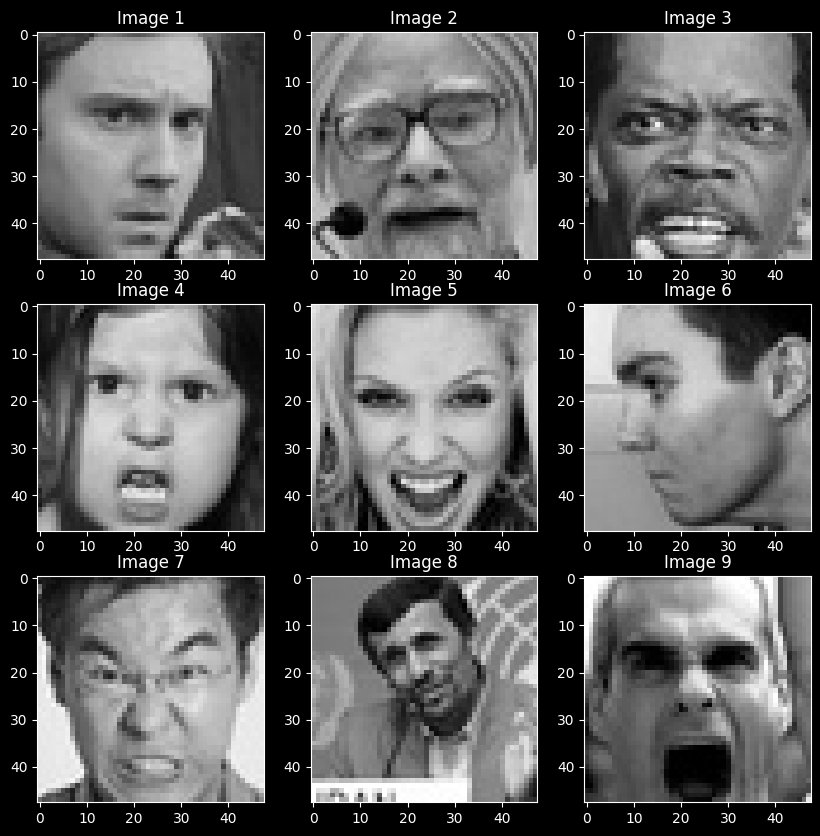

In [75]:
# Here we read in and plot 9 images, which clearly show them as 48X48 size and of poor quality (blurred and pixilated)
image_paths = []
for class_dir in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_dir)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            if os.path.isfile(img_path):
                image_paths.append(img_path)

plt.figure(figsize=(10, 10))
for i, img_path in enumerate(image_paths[:9]):
    img = load_img(img_path, target_size=(picture_size, picture_size))
    plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Image {i + 1}")
plt.show()

### Pre-processing Train and Validation Data

In [78]:
# Here we load the training/validataion datasets and split them into training and validation sets using dataset_from_directory instead of ImageDataGenerator which has been deprecated.
# We Limit the number of samples due to problems we anticipate with computer processing of this size dataset which has 28821 training images and based on parameters generated by the Neurons in the 
# CNNs hidden layers will likely be too slow to effectively train the model. So we take about 60% of the data for training and validation.

num_train_batches = 128  
num_val_batches = 40    

train_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(48, 48),
    class_names=emotion_labels,
    color_mode="grayscale",
    batch_size=batch_size,
    label_mode='int',
    shuffle=True
)

val_set = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    seed=123,
    image_size=(48, 48),
    color_mode="grayscale",
    batch_size=batch_size,
    label_mode='int',
    shuffle=False
)

limited_train_set = train_set.take(num_train_batches)
limited_val_set = val_set.take(num_val_batches)
limited_train_count = sum(1 for _ in limited_train_set)
limited_val_count = sum(1 for _ in limited_val_set)

print(f"Limited training set size: {limited_train_count * batch_size}")
print(f"Limited validation set size: {limited_val_count * batch_size}")

Found 28821 files belonging to 7 classes.
Found 7066 files belonging to 7 classes.
Limited training set size: 16384
Limited validation set size: 5120


In [79]:
# Double-check here that labels we assigned above as integers is correct (i.e. not one-hot-encoded) so as to also know later to use the right loss function.
for images, labels in limited_train_set.take(1):
    print(f'Labels shape: {labels.shape}')
    print(f'Labels: {labels.numpy()}')


Labels shape: (128,)
Labels: [5 4 3 0 2 5 3 6 0 4 6 5 2 2 6 3 2 3 0 3 3 5 5 5 6 2 2 5 1 5 2 5 6 6 4 0 4
 5 3 2 0 6 4 3 5 4 4 2 3 3 3 3 4 3 2 4 3 4 6 6 6 4 2 5 4 5 3 5 5 6 2 5 4 3
 0 2 1 6 4 3 2 0 0 1 6 0 6 5 3 0 0 2 3 5 4 0 0 2 3 3 5 4 0 4 3 6 3 3 5 3 3
 4 0 5 5 3 2 0 0 4 3 3 3 0 0 2 5 0]


In [ ]:
# Here we tried rescaling the images but performance went down so we removed it

#rescaling_layer = tf.keras.layers.Rescaling(1./255)
#def apply_rescaling(image, label):
#    image = rescaling_layer(image)
#    return image, label

#limited_train_set = limited_train_set.map(apply_rescaling, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#limited_val_set = limited_val_set.map(apply_rescaling, num_parallel_calls=tf.data.experimental.AUTOTUNE)

#limited_train_set = limited_train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#limited_val_set = limited_val_set.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

#def display_batch_of_images(images, labels):
#    plt.figure(figsize=(10, 10))
#    for i in range(9): 
#        ax = plt.subplot(3, 3, i + 1)
#        plt.imshow(images[i].numpy().squeeze(), cmap="gray")
#        plt.title(int(labels[i]))
#        plt.axis("off")
#for images, labels in limited_train_set.take(1):
#    display_batch_of_images(images, labels)
#    break 

In [80]:
# we check the datasets and see that the batches look correct in terms of the preprocessing for size and image size and grayscale assignment
for images, labels in limited_train_set.take(1):
    print(f'Training batch - images shape: {images.shape}, labels shape: {labels.shape}')

for images, labels in limited_val_set.take(1):
    print(f'Validation batch - images shape: {images.shape}, labels shape: {labels.shape}')

Training batch - images shape: (128, 48, 48, 1), labels shape: (128,)
Validation batch - images shape: (128, 48, 48, 1), labels shape: (128,)


### Model Building

In [81]:
# Here we largely kept the layout of the layers after having tried reducing the nodes in the 3rd and 4th hidden layers to 256 respectively. This did help a small bit to speed up 
# the training process but val_accuracy (went down to 35%) and val_loss got worse. 
# We tried reducing dimensionality by increasing the strides for padding to decrease the size of the steps taken by the kernel between input pixels, but while this did seem to help speed up training it also seemed to make val_accuracy go down.
# We tried data augmentation (see commented out section) but this resulted in more erratic training accuracy, which we understand as being likely due to the fact that the 
# dataset (albeit poor) does already have a fair degree of variation in it.
# We tried to increase Dropout on the 4th hidden layer to help the network reduce sensitivity to noise but it didn't improve performance and did slow down learning.

no_of_classes = 7

model = Sequential()

# Add preprocessing layers for data augmentation
#model.add(Rescaling(1./255, input_shape=(48, 48, 1)))
#model.add(RandomFlip('horizontal'))
#model.add(RandomRotation(0.1))
#model.add(RandomZoom(0.1))

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))

#opt = Adam(learning_rate = 0.0001)
#model.compile(optimizer=opt,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\rshaw\Desktop\EC Utbildning - Data Science\Kurs 7 - Deep Learning\Kunskapkontroll2-ComputerVision\Emotion_Detection_CNN\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_49 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_50 (Activation)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_51 (Activation)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 256)            │         1,02

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

# Fitting the Model with Training and Validation Data

In [99]:
# Despite adjusting the learning rate up and down from 0.001 to optimize gradient descent and minimize loss, we found no improvement in model performance. 
# Therefore, we reverted back to the original learning rate of 0.001. 

# We also tried increase early stopping patience to give the model more time to learn but again this didn't help.

# We used sparse_categorical_crossentropy as our loss function to work properly with the integer labels.

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./best_model_30.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.00001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 12 # We tried higher epochs but given early stopping this wasn't very useful. 

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [83]:
# We trained the model initially with class_weight and it caused the model to run very slowly, so we removed it. That said, it would be optimal to try and run it to help improve accuracy.

history = model.fit(limited_train_set,
                    epochs=epochs,
                    validation_data = limited_val_set,
                    #class_weight=class_weights,
                    callbacks=callbacks_list,
                    )

model.save('./best_emotion_model_30.keras')

Epoch 1/12
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2410 - loss: 2.0033
Epoch 1: val_accuracy improved from -inf to 0.40195, saving model to ./best_model_30.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.2413 - loss: 2.0024 - val_accuracy: 0.4020 - val_loss: 1.5417 - learning_rate: 0.0010
Epoch 2/12
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3649 - loss: 1.6411
Epoch 2: val_accuracy did not improve from 0.40195
128/128 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.3651 - loss: 1.6408 - val_accuracy: 0.2902 - val_loss: 1.6545 - learning_rate: 0.0010
Epoch 3/12
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4367 - loss: 1.4601
Epoch 3: val_accuracy improved from 0.40195 to 0.47988, saving model to ./best_model_30.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.4368 - loss: 1.4599 - val_accuracy: 0.4799 - val_loss: 1.5108 - learning_rate: 0.0010
Epoch 4/12
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4825 - loss: 1.338

### Plotting Accuracy & Loss

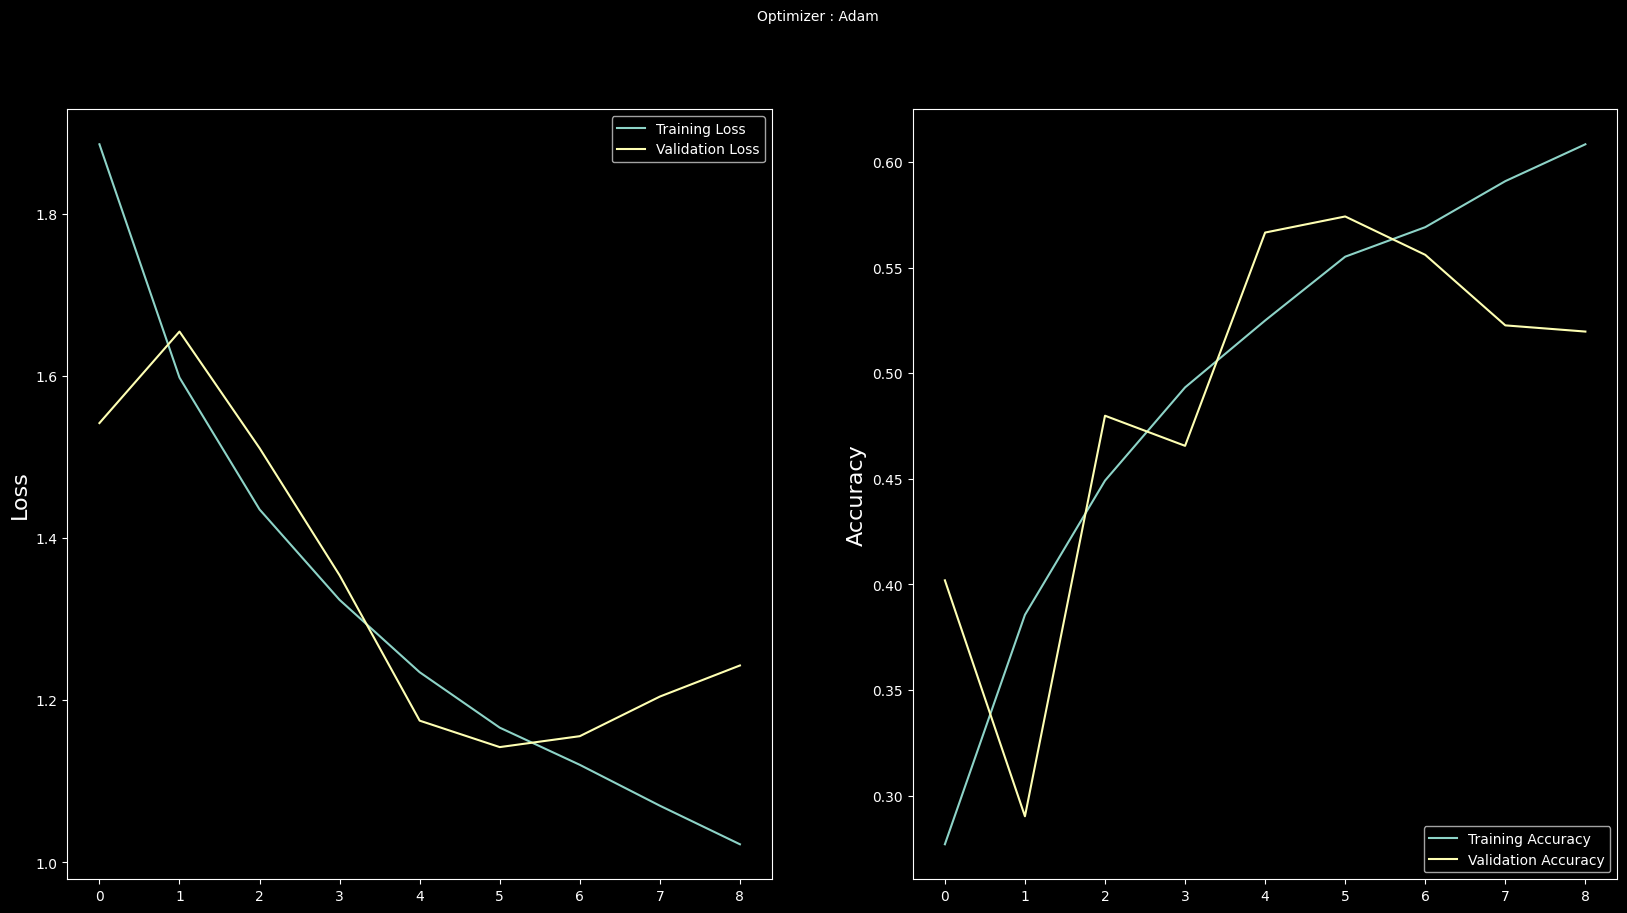

In [101]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

- The model showed significant improvements in both training and validation accuracy during the first few epochs, showing effective learning early on.

- Despite early progress, the model's validation accuracy plateaued and even decreased in later epochs. This led to early stopping and a reduction in the learning rate, suggesting possible overfitting or the need for further learning rate adjustments.

- The highest validation accuracy was 57.4% in Epoch 6. This was the peak performance before the model's accuracy started to drop, leading to the restoration of weights from this epoch.

In [88]:
new_model = tf.keras.models.load_model('best_emotion_model_30.keras')
new_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_49 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_50 (Activation)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_51 (Activation)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 256)            │         1,02

 Total params: 13,428,247 (51.22 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

 Optimizer params: 8,949,520 (34.14 MB)

56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 284ms/step


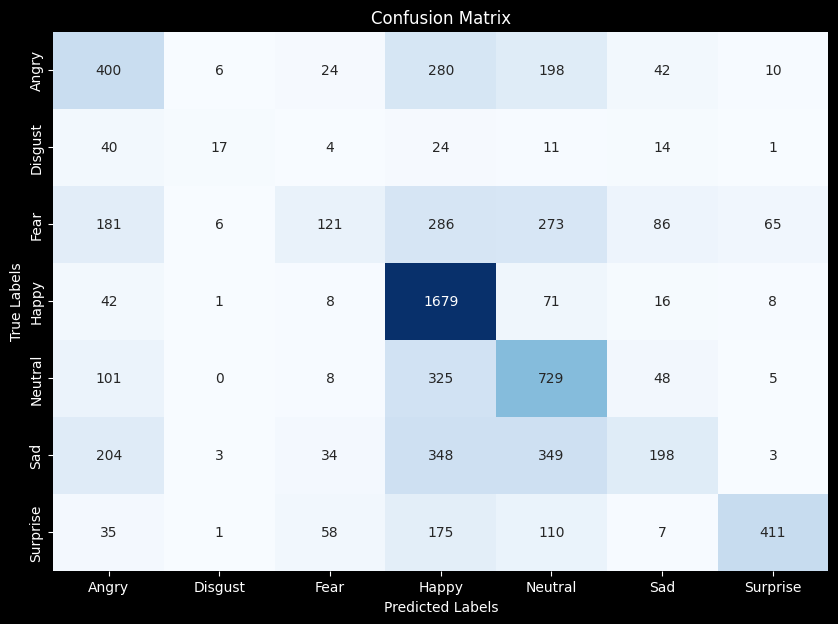

Classification Report:
              precision    recall  f1-score   support

       Angry       0.40      0.42      0.41       960
     Disgust       0.50      0.15      0.23       111
        Fear       0.47      0.12      0.19      1018
       Happy       0.54      0.92      0.68      1825
     Neutral       0.42      0.60      0.49      1216
         Sad       0.48      0.17      0.26      1139
    Surprise       0.82      0.52      0.63       797

    accuracy                           0.50      7066
   macro avg       0.52      0.41      0.41      7066
weighted avg       0.51      0.50      0.46      7066



In [100]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

true_labels = []
for images, labels in val_set:
    true_labels.extend(labels.numpy()) 
true_labels = np.array(true_labels)
predictions = np.argmax(new_model.predict(val_set), axis=1)

emotion_labels = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprise"}
emotion_names = [emotion_labels[i] for i in range(len(emotion_labels))]

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=emotion_names, yticklabels=emotion_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(true_labels, predictions, target_names=emotion_names)
print("Classification Report:")
print(report)


- From the confusion matrix and classification report we can see that the model did indeed struggle to identify correctly "Disgust" but found "Happy" easily w an f1-score of 0.68. 
- For "Surprise" the model has high precision (0.82) but moderate recall (0.52), suggesting it's good at identifying surprise but misses many instances. 
- For "Disgust" it has moderate precision (0.50) but very low recall (0.15), indicating the model often fails to detect "Disgust" accurately.

## Conclusion 

- The accuracy is 57%, so a bit lower than what we expected. I think this is largely due to the poor quality of the dataset and its imbalance between classes. 
- The next steps would be to try adding regularization techniques like L2 and adjust dropout, then running the entire dataset on a GPU and run class weights to help with improving recall. Then run it on a pretrained model and fine tune it. Then get a new dataset.

## Evaluation

1.	Challenges you have had during your work and how you handled them. 
The model only predicted sad initially, and then only happy. It was very slow on a GPU. So, I tried a range of techniques and reached out to classmates and found that part of the problem was in the inference script with color and threshold and once I changed these I got it to work. I also tried a pretrained model on ColabPRO but was having other difficulties getting this to work. I decided to find a better dataset for the gender model to make things run better.

2.	What grade you think you should have and why. 
VG as I think I got the emotion model (57% accuracy) to run and also went into great depth figuring it out and learning to successfully create the gender model with a pretrained model and transfer learning (w/ 85% accuracy).

3.	Tips you had "given to yourself" at the beginning of the course now that you have completed it. 
To try to rememember that even the smallest error can cause big problems.